# Strategic Market Intelligence: The Alimosho Soft Drink Ecosystem
### From Raw Survey Data to Actionable Retail Strategy

**Author:** Akinmade Faruq Adeoye  
**Context:** Alimosho Local Government Area, Lagos, Nigeria  
**Dataset:** 1,500 Geotagged Retail Outlets (Soft Drink Market Insight Challenge)

---

## 1. Executive Summary & Mission
This project goes beyond standard exploratory data analysis. We aim to deconstruct the **"Ground Truth"** of soft drink distribution in Alimosho. By analyzing 1,500 data points across supermarkets, kiosks, and street vendors, we will expose the operational realities of the market—specifically focusing on the **"Cold Chain Gap"** (availability of refrigerated product) and **"Share of Visibility"** (shelf dominance).

Our goal is to build a **Market Intelligence System** that answers three critical business questions:
1.  **The "Cold Premium" Reality:** Where are brands losing sales because they are available but *warm*?
2.  **The Guerrilla Warfare Map:** Which specific coordinates represent "Gap Opportunities" (where competitors are weak or absent)?
3.  **Outlet DNA:** Can we classify outlets not by what they *say* they are, but by their *stocking behavior*?

---

## 2. The Analytical Framework (Methodology)

We will execute this analysis in five strict phases to ensure rigor and reproducibility.

### Phase I: Data Forensics & Ingestion
* **Objective:** Load the raw 1,500-row dataset and perform a "Health Check."
* **Critical Action:** Identify missing values in critical operational columns (`Stock Condition`, `Latitude/Longitude`) and standardize column naming conventions to snake_case for Pythonic consistency.

### Phase II: The "Explosion" Strategy (Feature Engineering)
* **The Challenge:** The dataset contains "Combined Response" columns (e.g., `Product Display` containing "On shelf, In cooler" as a single string).
* **The Solution:** We will apply **One-Hot Encoding (Binary Decomposition)** to these columns.
    * *Convert:* "Coke, Pepsi, Bigi" $\rightarrow$ `Has_Coke` (1), `Has_Pepsi` (1), `Has_Bigi` (1).
    * *Convert:* "On Shelf, In Cooler" $\rightarrow$ `Is_Chilled` (1), `Is_Ambient` (1).
* **Metric Creation:** We will calculate a **"Cooling Efficiency Score"** for every outlet.

### Phase III: Strategic Analysis Layers
* **Layer A - Distribution vs. Availability:** A brand might be "listed," but is it in stock? We will filter for `Stock Condition != 'Out of Stock'` to find true availability.
* **Layer B - The Cold War:** We will cross-reference `Brand Presence` with `In Refrigerator` status. This reveals the "True Consumable Market Share" (since warm soda rarely sells for immediate consumption in Lagos).
* **Layer C - Geospatial "Kill Zones":** We will use `Latitude` and `Longitude` to map clusters where specific brands are totally absent despite high outlet density.

### Phase IV: The "Share of Throat" Segmentation
* **Segmentation:** We will analyze `Package Type` (Glass vs. PET vs. Can) to determine the economic profile of different neighborhoods in Alimosho.
    * *Hypothesis:* High "Glass Bottle" density indicates on-premise consumption hubs. High "Can" density indicates premium/convenience zones.

### Phase V: The Interactive Dashboard
* **Final Deliverable:** A Plotly/Dash-based interface allowing stakeholders to filter the map by Brand, Cooling Status, and Outlet Type to make immediate logistics decisions.

---

## 3. Technical Standards
* **Language:** Python 3.x
* **Core Libraries:** Pandas (Data Manipulation), Plotly Express (Interactive Geospatial Viz), Folium (Mapping), Seaborn (Statistical Viz).
* **Integrity Protocol:** All "Combined" text data will be rigorously parsed. No manual Excel manipulation is permitted; all cleaning is programmatic for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import re  # Regular Expressions for parsing messy text strings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

sns.set_theme(style="whitegrid")
%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = "jupyterlab"

In [2]:
file_path = 'Product Visibility Challenge Data.csv'

# Reload dataset specifying header=1 to skip the super-category row
df = pd.read_csv(file_path, header=1)

# Function to clean and standardize column names
def clean_column_names(df):
    # Convert to lowercase and strip whitespace
    df.columns = df.columns.str.lower().str.strip()
    # Remove punctuation and special characters
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)
    # Replace spaces with underscores
    df.columns = df.columns.str.replace(' ', '_')
    return df

# Apply cleaning function
df = clean_column_names(df)

# Drop S/N (Serial Number) as it is an index artifact
if 'sn' in df.columns:
    df = df.drop(columns=['sn'])

# Verify the fix
print(f"Data Reloaded Successfully.")
print(f"Shape: {df.shape}")
print("\nCorrected Column List:")
print(df.columns.tolist())

display(df.head())

Data Reloaded Successfully.
Shape: (1500, 37)

Corrected Column List:
['latitude', 'longitude', 'type_of_outlet', 'specify_type_of_outlet', 'type_of_product_combined_response', 'cocacola', 'pepsi', 'bigi', 'rc_cola', '7up', 'fanta', 'sprite', 'la_casera', 'schweppes', 'fayrouz', 'mirinda', 'mountain_dew', 'teem', 'american_cola', 'others', 'product_type__others', 'product_display_combined_response', 'on_shelfcarton', 'in_refridgeratorcooler', 'on_display_stand', 'with_consumer_actively_being_consumed', 'others1', 'product_display__others', 'package_type_combined', 'pet_bottle_50cl1l', 'glass_bottle_35cl60cl', 'can_33cl', 'others2', 'package_type__others', 'product_with_higher_shelfrefrigerator_presence', 'product_with_higher_shelfrefrigerator_presence__others', 'stock_condition']


,latitude,longitude,type_of_outlet,specify_type_of_outlet,type_of_product_combined_response,cocacola,pepsi,bigi,rc_cola,7up,fanta,sprite,la_casera,schweppes,fayrouz,mirinda,mountain_dew,teem,american_cola,others,product_type__others,product_display_combined_response,on_shelfcarton,in_refridgeratorcooler,on_display_stand,with_consumer_actively_being_consumed,others1,product_display__others,package_type_combined,pet_bottle_50cl1l,glass_bottle_35cl60cl,can_33cl,others2,package_type__others,product_with_higher_shelfrefrigerator_presence,product_with_higher_shelfrefrigerator_presence__others,stock_condition
0,6.634719,3.255957,Shop,NaN,Pepsi Sprite American Cola,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,NaN,On display stand,0,0,1,NaN,0,NaN,PET bottle (50cl/1L),1,0,0,0,NaN,Others,American cola,Well stocked
1,6.637297,3.257817,Shop,NaN,Others,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Malt,On display stand,0,0,1,NaN,0,NaN,PET bottle (50cl/1L) Can (33cl),1,0,1,0,NaN,All equal,NaN,Well stocked
2,6.639850,3.284733,Shop,NaN,Others,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Malt and voju milk,On display stand,0,0,1,NaN,0,NaN,PET bottle (50cl/1L),1,0,0,0,NaN,Others,Viju milk,Well stocked
3,6.657487,3.291203,Shop,NaN,Coca-Cola Fanta,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,On display stand,0,0,1,NaN,0,NaN,PET bottle (50cl/1L),1,0,0,0,NaN,Coke,NaN,Almost empty
4,6.657487,3.291203,Shop,NaN,Coca-Cola Fanta,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,On display stand,0,0,1,NaN,0,NaN,PET bottle (50cl/1L),1,0,0,0,NaN,NaN,NaN,Almost empty


In [3]:
# List of all binary indicator columns based on the dataset structure
binary_cols = [
    'cocacola', 'pepsi', 'bigi', 'rc_cola', '7up', 'fanta', 'sprite', 
    'la_casera', 'schweppes', 'fayrouz', 'mirinda', 'mountain_dew', 
    'teem', 'american_cola', 'others', 
    'on_shelfcarton', 'in_refridgeratorcooler', 'on_display_stand', 
    'with_consumer_actively_being_consumed', 'others1',
    'pet_bottle_50cl1l', 'glass_bottle_35cl60cl', 'can_33cl', 'others2'
]

# Fill NaNs with 0 and convert to integer type
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

# 2. Categorical Normalization
# Convert categorical columns to lowercase to avoid fragmentation 
categorical_cols = ['type_of_outlet', 'stock_condition', 'product_with_higher_shelfrefrigerator_presence']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].str.lower().str.strip()

# 3. Duplicate Removal
initial_count = len(df)
df = df.drop_duplicates()
final_count = len(df)

# 4. Geospatial Sanity Check (Lagos Constraints)
geo_outliers = df[
    (df['latitude'] < 6.0) | (df['latitude'] > 7.0) | 
    (df['longitude'] < 3.0) | (df['longitude'] > 4.0)
]

print(f"Rows Dropped (Duplicates): {initial_count - final_count}")
print(f"Geospatial Outliers Detected: {len(geo_outliers)}")
print("-" * 30)
print("Sample of Cleaned Binary Data:")
display(df[['type_of_outlet', 'cocacola', 'in_refridgeratorcooler', 'stock_condition']].head())

Rows Dropped (Duplicates): 0
Geospatial Outliers Detected: 0
------------------------------
Sample of Cleaned Binary Data:


,type_of_outlet,cocacola,in_refridgeratorcooler,stock_condition
0,shop,0,0,well stocked
1,shop,0,0,well stocked
2,shop,0,0,well stocked
3,shop,1,0,almost empty
4,shop,1,0,almost empty


In [4]:
# 1. Define the Competitive Set 
brand_columns = [
    'cocacola', 'pepsi', 'bigi', 'rc_cola', '7up', 'fanta', 'sprite', 
    'la_casera', 'schweppes', 'fayrouz', 'mirinda', 'mountain_dew', 
    'teem', 'american_cola'
]

# 2. Calculate 'Brand Portfolio Size' (Market Saturation Metric).
df['brand_portfolio_size'] = df[brand_columns].sum(axis=1)

# 3. Derive 'Cold Chain Status' (The Efficiency Metric)
# We map the binary 0/1 to human-readable labels for the dashboard.
def define_cold_status(row):
    if row['in_refridgeratorcooler'] == 1:
        return 'Chilled'
    else:
        return 'Ambient (Warm)'

df['cold_chain_status'] = df.apply(define_cold_status, axis=1)

# 4. Consolidate Package Type (The Economic Proxy)
# We determine the dominant package type for the outlet.
# Priority Logic: If they have Glass, they are likely 'On-Premise'. If they have Cans, they are 'Premium'.
def determine_primary_package(row):
    if row['glass_bottle_35cl60cl'] == 1:
        return 'Glass (Returnable)'
    elif row['can_33cl'] == 1:
        return 'Can (Premium)'
    elif row['pet_bottle_50cl1l'] == 1:
        return 'PET (Plastic)'
    else:
        return 'Unspecified'

df['primary_package'] = df.apply(determine_primary_package, axis=1)

# 5. Filter for Active Outlets
# We create a subset of data that excludes "Out of Stock" locations for availability analysis.
# An outlet with no stock is an operational failure, not a market participant.
active_outlets = df[df['stock_condition'] != 'out of stock']

print("Feature Engineering Complete.")
print("-" * 30)
print("New KPI Summary:")
print(df[['type_of_outlet', 'brand_portfolio_size', 'cold_chain_status', 'primary_package']].head(10))
print("-" * 30)
print(f"Active Outlets (Stock Available): {len(active_outlets)} / {len(df)}")

Feature Engineering Complete.
------------------------------
New KPI Summary:
  type_of_outlet  brand_portfolio_size cold_chain_status     primary_package
0           shop                     3    Ambient (Warm)       PET (Plastic)
1           shop                     0    Ambient (Warm)       Can (Premium)
2           shop                     0    Ambient (Warm)       PET (Plastic)
3           shop                     2    Ambient (Warm)       PET (Plastic)
4           shop                     2    Ambient (Warm)       PET (Plastic)
5           shop                     4    Ambient (Warm)  Glass (Returnable)
6           shop                     2    Ambient (Warm)       PET (Plastic)
7           shop                     4    Ambient (Warm)       PET (Plastic)
8           shop                     3    Ambient (Warm)       Can (Premium)
9           shop                     0    Ambient (Warm)       PET (Plastic)
------------------------------
Active Outlets (Stock Available): 1486 / 150

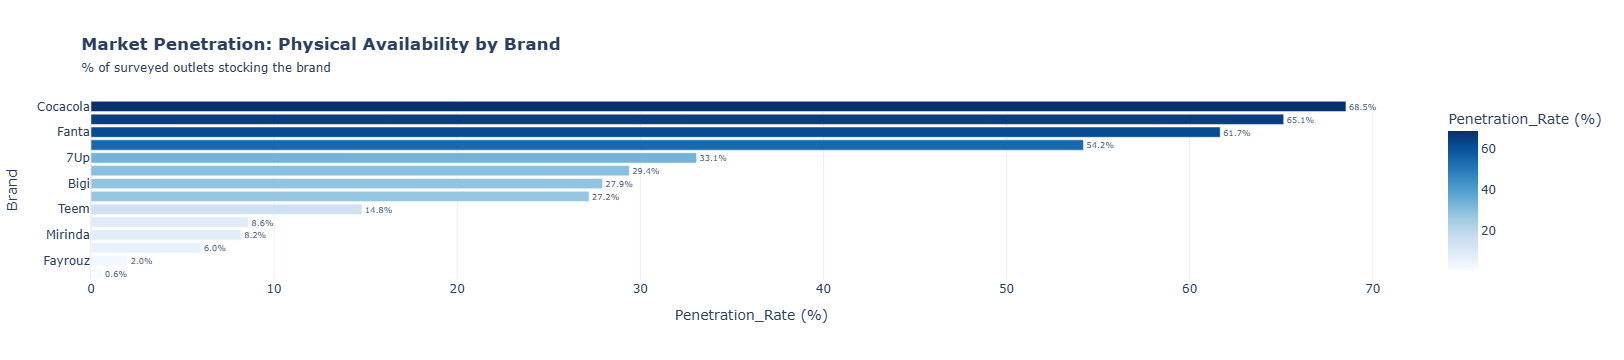

,Brand,Outlet_Count,Penetration_Rate (%)
0,Cocacola,1028,68.533333
1,Pepsi,977,65.133333
2,Fanta,925,61.666667
3,American Cola,813,54.200000
4,7Up,496,33.066667
5,Sprite,441,29.400000
6,Bigi,419,27.933333
7,La Casera,408,27.200000
8,Teem,222,14.800000
9,Schweppes,129,8.600000


In [5]:
brand_counts = df[brand_columns].sum().sort_values(ascending=False)

# 2. Convert to Percentage (Penetration Rate)
# Penetration = (Stores with Brand / Total Active Stores) * 100
total_outlets = len(df)
brand_penetration = (brand_counts / total_outlets) * 100

# 3. Create a DataFrame for Visualization
penetration_df = pd.DataFrame({
    'Brand': brand_counts.index.str.replace('_', ' ').str.title(), # Clean names for display
    'Outlet_Count': brand_counts.values,
    'Penetration_Rate (%)': brand_penetration.values
})

# 4. Visualize with Plotly (Interactive)
fig = px.bar(
    penetration_df, 
    x='Penetration_Rate (%)', 
    y='Brand', 
    orientation='h',
    text='Penetration_Rate (%)',
    title='<b>Market Penetration: Physical Availability by Brand</b><br><span style="font-size: 12px;">% of surveyed outlets stocking the brand</span>',
    color='Penetration_Rate (%)',
    color_continuous_scale='Blues'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis=dict(autorange="reversed"), template='plotly_white')

fig.show()

# Output the raw table for inspection
display(penetration_df.head(10))

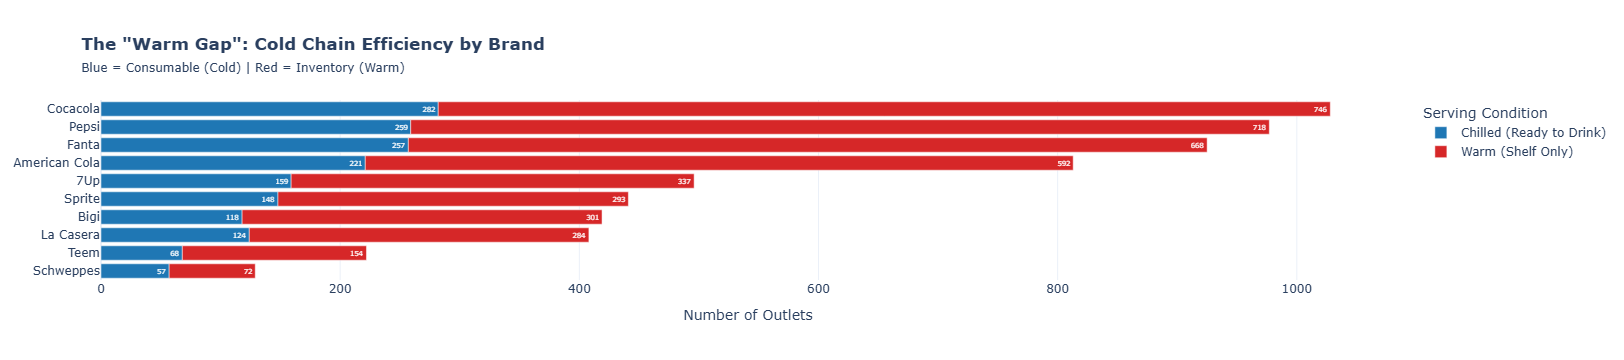

Cold Chain Efficiency Leaders (Percentage of stock found in coolers):


,Brand,Efficiency
18,Schweppes,44.186047
10,Sprite,33.560091
8,7Up,32.056452
16,Teem,30.630631
14,La Casera,30.392157
12,Bigi,28.162291
4,Fanta,27.783784
0,Cocacola,27.431907
6,American Cola,27.183272
2,Pepsi,26.509724


In [6]:
# 1. Define the "Cold Proxy"
# We assume if a brand is present (1) AND the outlet has a cooler (1), the brand is "Cold Available".
# If a brand is present (1) but cooler is (0), the brand is "Warm".

# Initialize storage for metrics
cold_metrics = []

# We'll focus on the Top 10 brands from the previous step to keep the chart readable
top_brands = penetration_df.head(10)['Brand'].str.lower().str.replace(' ', '_').values

# Loop through each brand to calculate Cold vs. Warm counts
for brand in top_brands:
    # Fix brand naming mismatch if necessary (e.g. 'coca_cola' vs 'cocacola')
    # The previous step cleaned names to title case with spaces, we need to revert to column names
    # Let's map them manually or ensure strict matching.
    # Actual column name for 'Coca Cola' is 'cocacola'.
    col_name = brand.replace('_', '') if brand == 'coca_cola' else brand
    col_name = 'rc_cola' if brand == 'rc_cola' else col_name # RC Cola usually matches
    
    # Verify column exists before processing
    if col_name in df.columns:
        # Total stores with this brand
        total_presence = df[col_name].sum()
        
        # Stores with Brand AND Cooler
        cold_presence = df[(df[col_name] == 1) & (df['in_refridgeratorcooler'] == 1)].shape[0]
        
        # Stores with Brand but NO Cooler (Warm)
        warm_presence = total_presence - cold_presence
        
        # Calculate Efficiency Ratio
        efficiency_ratio = (cold_presence / total_presence) * 100 if total_presence > 0 else 0
        
        cold_metrics.append({
            'Brand': col_name.replace('_', ' ').title(),
            'Condition': 'Chilled (Ready to Drink)',
            'Count': cold_presence,
            'Total': total_presence,
            'Efficiency': efficiency_ratio
        })
        cold_metrics.append({
            'Brand': col_name.replace('_', ' ').title(),
            'Condition': 'Warm (Shelf Only)',
            'Count': warm_presence,
            'Total': total_presence,
            'Efficiency': efficiency_ratio
        })

# 2. Create DataFrame
cold_df = pd.DataFrame(cold_metrics)

# 3. Sort by Total Presence (to match previous chart order)
cold_df = cold_df.sort_values(by='Total', ascending=True)

# 4. Visualize with Plotly (Stacked Bar)
fig_cold = px.bar(
    cold_df, 
    x='Count', 
    y='Brand', 
    color='Condition',
    title='<b>The "Warm Gap": Cold Chain Efficiency by Brand</b><br><span style="font-size: 12px;">Blue = Consumable (Cold) | Red = Inventory (Warm)</span>',
    text='Count',
    orientation='h',
    color_discrete_map={'Chilled (Ready to Drink)': '#1f77b4', 'Warm (Shelf Only)': '#d62728'}
)

# 5. Add Efficiency Annotations
# We want to show the % of stock that is cold right on the chart
fig_cold.update_traces(texttemplate='%{text}', textposition='inside')
fig_cold.update_layout(
    legend_title_text='Serving Condition',
    xaxis_title='Number of Outlets',
    yaxis_title=None,
    template='plotly_white'
)

fig_cold.show()

# Display the raw "Efficiency Leaderboard"
efficiency_table = cold_df[cold_df['Condition'] == 'Chilled (Ready to Drink)'][['Brand', 'Efficiency']].sort_values(by='Efficiency', ascending=False)
print("Cold Chain Efficiency Leaders (Percentage of stock found in coolers):")
display(efficiency_table)

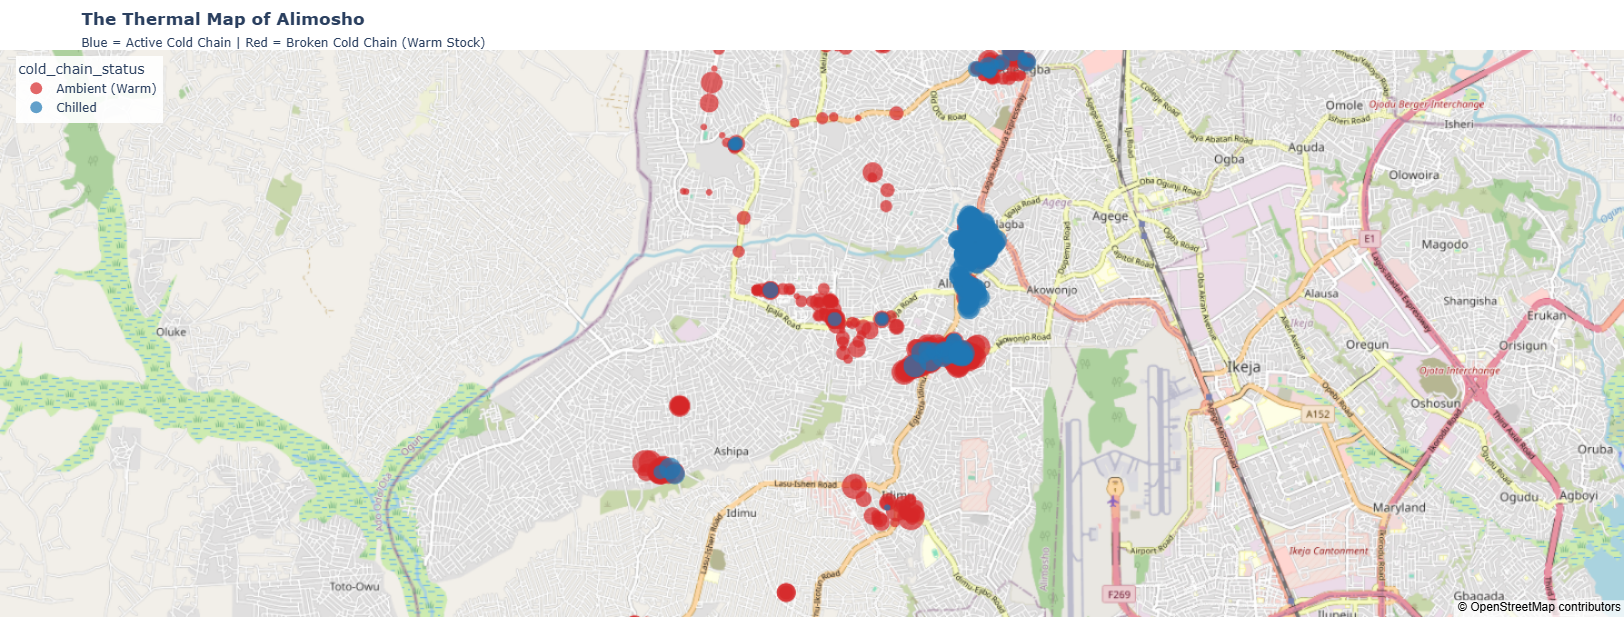

In [7]:
# 1. Configure the Map
fig_map = px.scatter_mapbox(
    df,
    lat="latitude",
    lon="longitude",
    color="cold_chain_status",
    size="brand_portfolio_size",
    hover_name="type_of_outlet",
    hover_data={
        "latitude": False, 
        "longitude": False, 
        "brand_portfolio_size": True, 
        "primary_package": True
    },
    color_discrete_map={"Chilled": "#1f77b4", "Ambient (Warm)": "#d62728"},
    zoom=12,
    title="<b>The Thermal Map of Alimosho</b><br><span style='font-size:12px;'>Blue = Active Cold Chain | Red = Broken Cold Chain (Warm Stock)</span>",
    height=600
)

# 2. Refine Map Aesthetics
fig_map.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":50,"l":0,"b":0},
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.9)"
    )
)

fig_map.show()

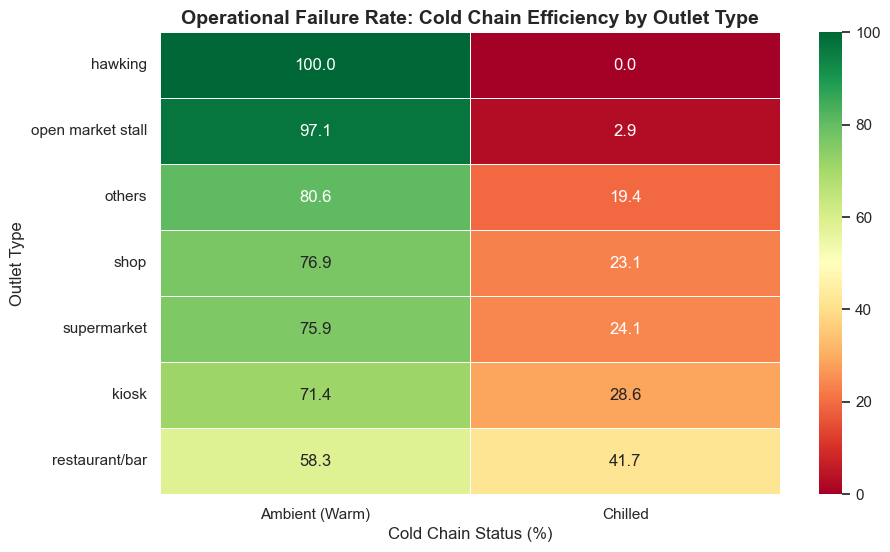

Ghost Outlets Detected (Stocked but no Major Brands): 12
Top 5 Ghost Outlet Types:
type_of_outlet
shop           11
supermarket     1
Name: count, dtype: int64


In [8]:
# Cell 10: The "Retail Failure" Matrix (Outlet Type Analysis)

# 1. Create the Cross-Tabulation (Contingency Table)
# We count how many of each outlet type are Chilled vs. Ambient.
outlet_cold_stats = pd.crosstab(
    df['type_of_outlet'], 
    df['cold_chain_status'], 
    normalize='index' # Converts counts to percentages per row
) * 100

# 2. Sort by 'Chilled' percentage to see best performers at the top
outlet_cold_stats = outlet_cold_stats.sort_values(by='Chilled', ascending=True)

# 3. Visualize with a Heatmap (Seaborn)
# We use a heatmap because it immediately highlights "Red Zones" (Low Chilling).
plt.figure(figsize=(10, 6))
sns.heatmap(
    outlet_cold_stats, 
    annot=True, 
    fmt=".1f", 
    cmap="RdYlGn", # Red (Bad) to Green (Good)
    linewidths=.5
)

plt.title('Operational Failure Rate: Cold Chain Efficiency by Outlet Type', fontsize=14, fontweight='bold')
plt.ylabel('Outlet Type')
plt.xlabel('Cold Chain Status (%)')
plt.show()

# 4. The "Ghost Outlet" Check
# Remember those shops with 0 brands? Let's see what type they are.
ghost_outlets = df[df['brand_portfolio_size'] == 0]
print(f"Ghost Outlets Detected (Stocked but no Major Brands): {len(ghost_outlets)}")
print("Top 5 Ghost Outlet Types:")
print(ghost_outlets['type_of_outlet'].value_counts().head())

In [9]:
# We want to know: For every Outlet Type, what is the dominant Package Type?
package_mix = pd.crosstab(
    df['type_of_outlet'],
    df['primary_package'],
    normalize='index'
) * 100

# 2. Reset index for Plotly
package_mix = package_mix.reset_index()

# 3. Melt for Visualization
package_long = package_mix.melt(
    id_vars='type_of_outlet', 
    var_name='Package_Type', 
    value_name='Share_Percentage'
)

# 4. Visualizing the "Consumption Mode"
fig_pack = px.bar(
    package_long,
    x='Share_Percentage',
    y='type_of_outlet',
    color='Package_Type',
    title='<b>Consumption Architecture: Packaging Mix by Outlet Type</b>',
    orientation='h',
    text='Share_Percentage',
    color_discrete_map={
        'Glass (Returnable)': '#2ca02c', # Green for Glass
        'Can (Premium)': '#ff7f0e',      # Orange for Cans
        'PET (Plastic)': '#1f77b4',      # Blue for PET
        'Unspecified': '#7f7f7f'
    }
)

# 5. Refine Aesthetics
fig_pack.update_traces(texttemplate='%{text:.1f}%', textposition='inside')
fig_pack.update_layout(
    barmode='stack',
    xaxis_title='Share of Outlet Mix (%)',
    yaxis_title=None,
    legend_title_text='Primary Package',
    template='plotly_white'
)

fig_pack.show()

# 6. The "Can" Index (Premium Opportunity)
# Which outlet type surprisingly stocks the most cans?
can_leaders = package_long[package_long['Package_Type'] == 'Can (Premium)'].sort_values(by='Share_Percentage', ascending=False)
print("The 'Premium Convenience' Index (Outlets stocking Cans):")
display(can_leaders[['type_of_outlet', 'Share_Percentage']])

The 'Premium Convenience' Index (Outlets stocking Cans):


,type_of_outlet,Share_Percentage
6,supermarket,17.241379
4,restaurant/bar,8.333333
2,open market stall,5.714286
1,kiosk,3.571429
5,shop,3.413499
0,hawking,0.000000
3,others,0.000000


In [10]:
# Cell 12: Install Dash Framework
# Note: If you already have Dash installed, this will simply satisfy the requirement.
try:
    import dash
    from dash import dcc, html
    from dash.dependencies import Input, Output
except ImportError:
    !pip install dash
    import dash
    from dash import dcc, html
    from dash.dependencies import Input, Output

In [11]:
# Cell 13: The Market Intelligence Dashboard

# Initialize the App
app = dash.Dash(__name__)

# --- 1. Layout Design (The "Command Center" Look) ---
app.layout = html.Div(style={'backgroundColor': '#f4f4f4', 'font-family': 'Arial, sans-serif', 'padding': '20px'}, children=[
    
    # Header Section
    html.Div([
        html.H1("Alimosho Market Intelligence Command Center", style={'color': '#2c3e50', 'textAlign': 'center'}),
        html.P("Operational Dashboard: Cold Chain Efficiency & Competitive Landscape", style={'textAlign': 'center', 'color': '#7f8c8d'}),
    ], style={'marginBottom': '30px'}),

    # Top Row: Key Metrics & Controls
    html.Div([
        # Left: Controls
        html.Div([
            html.Label("Filter by Outlet Type:", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='outlet-dropdown',
                options=[{'label': 'All Outlets', 'value': 'ALL'}] + 
                        [{'label': i.title(), 'value': i} for i in df['type_of_outlet'].unique()],
                value='ALL',
                clearable=False
            ),
            html.Br(),
            html.Div(id='live-stats-card', style={'padding': '15px', 'backgroundColor': 'white', 'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)'})
        ], style={'width': '25%', 'display': 'inline-block', 'verticalAlign': 'top', 'marginRight': '2%'}),

        # Right: The Thermal Map (The Main Event)
        html.Div([
            dcc.Graph(id='main-map')
        ], style={'width': '70%', 'display': 'inline-block', 'verticalAlign': 'top', 'backgroundColor': 'white', 'padding': '10px', 'borderRadius': '5px'})
    ], style={'marginBottom': '20px'}),

    # Middle Row: Deep Dive Charts
    html.Div([
        # Chart 1: The Cold Chain Gap
        html.Div([
            dcc.Graph(id='cold-chain-chart')
        ], style={'width': '48%', 'display': 'inline-block', 'marginRight': '2%', 'backgroundColor': 'white', 'padding': '10px', 'borderRadius': '5px'}),

        # Chart 2: Packaging Mix
        html.Div([
            dcc.Graph(id='packaging-chart')
        ], style={'width': '48%', 'display': 'inline-block', 'backgroundColor': 'white', 'padding': '10px', 'borderRadius': '5px'})
    ])
])

# --- 2. Callbacks (The Brains) ---
@app.callback(
    [Output('main-map', 'figure'),
     Output('cold-chain-chart', 'figure'),
     Output('packaging-chart', 'figure'),
     Output('live-stats-card', 'children')],
    [Input('outlet-dropdown', 'value')]
)
def update_dashboard(selected_outlet):
    # Filter Data
    if selected_outlet == 'ALL':
        filtered_df = df
        subtitle = "All Zones"
    else:
        filtered_df = df[df['type_of_outlet'] == selected_outlet]
        subtitle = f"Filtering for: {selected_outlet.title()}"

    # --- KPI Calculation ---
    total_outlets = len(filtered_df)
    chilled_outlets = filtered_df[filtered_df['cold_chain_status'] == 'Chilled'].shape[0]
    chilled_pct = (chilled_outlets / total_outlets * 100) if total_outlets > 0 else 0
    
    stats_card = [
        html.H4("Zone Vital Signs"),
        html.P(f"Active Outlets: {total_outlets}"),
        html.P(f"Cold Chain Efficiency: {chilled_pct:.1f}%", style={'color': 'green' if chilled_pct > 50 else 'red', 'fontWeight': 'bold'}),
        html.P("Most Common Brand: " + (filtered_df[brand_columns].sum().idxmax().title() if total_outlets > 0 else "N/A"))
    ]

    # --- Update Map ---
    fig_map = px.scatter_mapbox(
        filtered_df, lat="latitude", lon="longitude", color="cold_chain_status",
        size="brand_portfolio_size", hover_name="type_of_outlet",
        color_discrete_map={"Chilled": "#1f77b4", "Ambient (Warm)": "#d62728"},
        zoom=11, height=400, title=f"<b>Geospatial Distribution</b>: {subtitle}"
    )
    fig_map.update_layout(mapbox_style="open-street-map", margin={"r":0,"t":40,"l":0,"b":0})

    # --- Update Cold Chain Chart ---
    # Recalculate cold stats for the filtered view
    current_brands = filtered_df[brand_columns].sum().sort_values(ascending=False).head(7).index
    cold_counts = []
    for b in current_brands:
        total = filtered_df[b].sum()
        cold = filtered_df[(filtered_df[b] == 1) & (filtered_df['in_refridgeratorcooler'] == 1)].shape[0]
        cold_counts.append({'Brand': b.title(), 'Status': 'Chilled', 'Count': cold})
        cold_counts.append({'Brand': b.title(), 'Status': 'Warm', 'Count': total - cold})
    
    fig_cold = px.bar(pd.DataFrame(cold_counts), x='Count', y='Brand', color='Status',
                      orientation='h', title="<b>Cold Availability Gap</b> (Selected Zone)",
                      color_discrete_map={'Chilled': '#1f77b4', 'Warm': '#d62728'})
    fig_cold.update_layout(barmode='stack', template='plotly_white', margin={"l":0})

    # --- Update Packaging Chart ---
    pack_counts = filtered_df['primary_package'].value_counts().reset_index()
    pack_counts.columns = ['Package', 'Count']
    fig_pack = px.pie(pack_counts, names='Package', values='Count', 
                      title="<b>Packaging Economy</b> (Selected Zone)",
                      color_discrete_map={'Glass (Returnable)': '#2ca02c', 'Can (Premium)': '#ff7f0e', 'PET (Plastic)': '#1f77b4'})

    return fig_map, fig_cold, fig_pack, stats_card

# --- 3. Run Server ---
if __name__ == '__main__':
    print("🚀 Launching Command Center...")
    app.run(mode='inline', port=8051)

🚀 Launching Command Center...


In [12]:
try:
    import dash_bootstrap_components as dbc
except ImportError:
    !pip install dash-bootstrap-components
    import dash_bootstrap_components as dbc
    

import plotly.io as pio


pio.templates["executive_dark"] = pio.templates["plotly_dark"]

theme = {
    'background': '#0f172a',       # Deep Slate (Main Background)
    'card_bg': '#1e293b',          # Lighter Slate (Card Background)
    'text': '#f1f5f9',             # Off-White (Primary Text)
    'subtext': '#94a3b8',          # Muted Grey (Labels)
    'accent': '#3b82f6',           # Electric Blue (Primary Actions)
    'positive': '#22c55e',         # Neon Green (Success)
    'negative': '#ef4444',         # Neon Red (Failure/Warm)
    'font': 'Inter, sans-serif'    # Modern clean font family
}

pio.templates["executive_dark"].layout.paper_bgcolor = 'rgba(0,0,0,0)' # Transparent background
pio.templates["executive_dark"].layout.plot_bgcolor = 'rgba(0,0,0,0)'  # Transparent plot area
pio.templates["executive_dark"].layout.font = {'color': theme['text']}
pio.templates.default = "executive_dark"

In [13]:
def create_kpi_card(title, value, subtext=None, color="primary", icon=None):
    """
    Generates a styled KPI card matching the 'Executive Dark' theme.
    
    Args:
        title (str): The label (e.g., "Total Revenue")
        value (str): The big number (e.g., "$6.7M")
        subtext (str): Optional context (e.g., "▼ 3% vs Last Month")
        color (str): Bootstrap color class (primary, success, danger)
        icon (str): Optional emoji or icon character
    """
    
    
    text_color = "#94a3b8" # Default muted grey
    if color == "success": text_color = "#22c55e" # Neon Green
    if color == "danger": text_color = "#ef4444"  # Neon Red
    if color == "primary": text_color = "#3b82f6" # Electric Blue

    card_content = [
        dbc.CardBody([
            html.H6(title.upper(), style={'color': '#94a3b8', 'fontSize': '12px', 'fontWeight': 'bold', 'letterSpacing': '1px'}),
            html.H2(value, style={'color': '#f1f5f9', 'fontWeight': 'bold', 'fontSize': '36px', 'marginTop': '5px'}),
            html.P(subtext, style={'color': text_color, 'fontSize': '14px', 'marginTop': '-5px', 'fontWeight': '500'}) if subtext else None
        ])
    ]
    
    return dbc.Card(
        card_content,
        style={
            'backgroundColor': '#1e293b', # background color
            'border': 'none',
            'borderRadius': '8px',
            'boxShadow': '0 4px 6px -1px rgba(0, 0, 0, 0.3)'
        },
        className="mb-4" # Margin bottom for spacing
    )

In [15]:
# Initialize the App with Slate Theme (Dark Mode)
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.SLATE])

app.layout = dbc.Container([
    
    dbc.Row([
        dbc.Col([
            html.H1("ALIMOSHO MARKET INTELLIGENCE", style={'color': '#fff', 'fontWeight': 'bold', 'letterSpacing': '2px', 'marginTop': '20px'}),
            html.P("STRATEGIC OPERATIONS CENTER: LOGISTICS, QUALITY, & COMPETITION", style={'color': '#94a3b8', 'fontSize': '12px', 'fontWeight': 'bold', 'letterSpacing': '1px'}),
        ], width=10),
        dbc.Col([
            html.Label("FILTER ZONE", style={'color': '#94a3b8', 'fontSize': '10px', 'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='outlet-dropdown',
                options=[{'label': 'ALL OUTLETS', 'value': 'ALL'}] + 
                        [{'label': i.upper(), 'value': i} for i in df['type_of_outlet'].unique()],
                value='ALL',
                clearable=False,
                style={'color': '#0f172a', 'fontWeight': 'bold'}
            )
        ], width=2, style={'marginTop': '25px'})
    ], className="mb-4"),

    
    html.Div(id='kpi-row', className="mb-2"),

    
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("COLD CHAIN GAP (VOLUME)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([dcc.Graph(id='cold-chart', config={'displayModeBar': False})], style={'backgroundColor': '#1e293b'})
            ], style={'border': 'none', 'borderRadius': '8px'})
        ], width=6),

        dbc.Col([
            dbc.Card([
                dbc.CardHeader("CONSUMPTION ARCHITECTURE (PACKAGING)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([dcc.Graph(id='pack-chart', config={'displayModeBar': False})], style={'backgroundColor': '#1e293b'})
            ], style={'border': 'none', 'borderRadius': '8px'})
        ], width=6)
    ], className="mb-4"),

    
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("SUPPLY CHAIN HEALTH (STOCK LEVELS)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([dcc.Graph(id='stock-chart', config={'displayModeBar': False})], style={'backgroundColor': '#1e293b'})
            ], style={'border': 'none', 'borderRadius': '8px'})
        ], width=6),

        dbc.Col([
            dbc.Card([
                dbc.CardHeader("OPERATIONAL FAILURE HEATMAP (%)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([dcc.Graph(id='heat-chart', config={'displayModeBar': False})], style={'backgroundColor': '#1e293b'})
            ], style={'border': 'none', 'borderRadius': '8px'})
        ], width=6)
    ], className="mb-4"),

    
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("TOTAL SHELF PENETRATION (%)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([dcc.Graph(id='pen-chart', config={'displayModeBar': False})], style={'backgroundColor': '#1e293b'})
            ], style={'border': 'none', 'borderRadius': '8px'})
        ], width=6),

        dbc.Col([
            dbc.Card([
                dbc.CardHeader("COMPETITION MATRIX (CORRELATION)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([dcc.Graph(id='matrix-chart', config={'displayModeBar': False})], style={'backgroundColor': '#1e293b'})
            ], style={'border': 'none', 'borderRadius': '8px'})
        ], width=6)
    ], className="mb-4"),

    
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("GEOSPATIAL THERMAL LAYER (EXPLORATION)", style={'color': '#fff', 'fontWeight': 'bold', 'backgroundColor': '#1e293b', 'borderBottom': '1px solid #334155'}),
                dbc.CardBody([
                    dcc.Graph(id='main-map', style={'height': '600px'}) # Increased height for immersion
                ], style={'backgroundColor': '#1e293b', 'padding': '0px'})
            ], style={'border': 'none', 'borderRadius': '8px', 'overflow': 'hidden'})
        ], width=12)
    ], className="mb-5")

], fluid=True, style={'backgroundColor': '#0f172a', 'minHeight': '100vh', 'padding': '20px'})



@app.callback(
    [Output('kpi-row', 'children'),
     Output('main-map', 'figure'),
     Output('cold-chart', 'figure'),
     Output('pack-chart', 'figure'),
     Output('stock-chart', 'figure'),
     Output('heat-chart', 'figure'),
     Output('pen-chart', 'figure'),
     Output('matrix-chart', 'figure')],
    [Input('outlet-dropdown', 'value')]
)
def update_dashboard(selected_outlet):
    
    
    if selected_outlet == 'ALL':
        dff = df
        heatmap_df = df 
    else:
        dff = df[df['type_of_outlet'] == selected_outlet]
        heatmap_df = df[df['type_of_outlet'] == selected_outlet]

    
    total_outlets = len(dff)
    chilled_count = dff[dff['cold_chain_status'] == 'Chilled'].shape[0]
    efficiency = (chilled_count / total_outlets * 100) if total_outlets > 0 else 0
    
    leader_brand = dff[brand_columns].sum().idxmax() if total_outlets > 0 else "N/A"
    leader_val = (dff[leader_brand].sum() / total_outlets * 100) if total_outlets > 0 else 0
    ghost_count = dff[dff['brand_portfolio_size'] == 0].shape[0]
    eff_color = "danger" if efficiency < 30 else "success" if efficiency > 50 else "primary"
    
    kpi_cards = dbc.Row([
        dbc.Col(create_kpi_card("Active Outlets", f"{total_outlets:,}", "Total Surveyed Points", "primary"), width=3),
        dbc.Col(create_kpi_card("Cold Efficiency", f"{efficiency:.1f}%", "Chilled Availability Rate", eff_color), width=3),
        dbc.Col(create_kpi_card("Market Leader", leader_brand.replace('_', ' ').title(), f"{leader_val:.1f}% Penetration", "primary"), width=3),
        dbc.Col(create_kpi_card("Ghost Outlets", str(ghost_count), "Stocked but Unbranded", "danger" if ghost_count > 0 else "success"), width=3),
    ])

    
    fig_map = px.scatter_mapbox(
        dff, lat="latitude", lon="longitude", color="cold_chain_status",
        size="brand_portfolio_size", hover_name="type_of_outlet",
        color_discrete_map={"Chilled": "#3b82f6", "Ambient (Warm)": "#ef4444"},
        zoom=11, opacity=0.8
    )
    fig_map.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0}, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)", showlegend=False)

    
    top_brands = dff[brand_columns].sum().sort_values(ascending=False).head(7).index
    cold_data = []
    for b in top_brands:
        total = dff[b].sum()
        cold = dff[(dff[b] == 1) & (dff['in_refridgeratorcooler'] == 1)].shape[0]
        cold_data.append({'Brand': b.replace('_',' ').title(), 'Status': 'Chilled', 'Count': cold})
        cold_data.append({'Brand': b.replace('_',' ').title(), 'Status': 'Warm', 'Count': total - cold})
    fig_cold = px.bar(pd.DataFrame(cold_data), x='Count', y='Brand', color='Status', orientation='h', color_discrete_map={'Chilled': '#3b82f6', 'Warm': '#ef4444'})
    fig_cold.update_layout(template='plotly_dark', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', barmode='stack', margin={"l":0, "r":0, "t":10, "b":0}, legend=dict(orientation="h", y=1.1, title=None))

    
    pack_counts = dff['primary_package'].value_counts().reset_index()
    pack_counts.columns = ['Package', 'Count']
    fig_pack = px.pie(pack_counts, names='Package', values='Count', hole=0.6, color='Package', color_discrete_map={'Glass (Returnable)': '#22c55e', 'Can (Premium)': '#f59e0b', 'PET (Plastic)': '#3b82f6'})
    fig_pack.update_layout(template='plotly_dark', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', margin={"l":0, "r":0, "t":10, "b":0}, showlegend=True, legend=dict(orientation="h", y=-0.1))

    
    stock_data = []
    for b in top_brands:
        if dff[b].sum() > 0:
            brand_stock = dff[dff[b] == 1]['stock_condition'].value_counts(normalize=True) * 100
            for cond, pct in brand_stock.items():
                stock_data.append({'Brand': b.replace('_',' ').title(), 'Condition': cond.title(), 'Percentage': pct})
    fig_stock = px.bar(pd.DataFrame(stock_data), y='Brand', x='Percentage', color='Condition', orientation='h', color_discrete_map={'Well Stocked': '#22c55e', 'Scanty': '#f59e0b', 'Almost Empty': '#ef4444', 'Out Of Stock': '#64748b'})
    fig_stock.update_layout(template='plotly_dark', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', barmode='stack', margin={"l":0, "r":10, "t":10, "b":0}, legend=dict(orientation="h", y=-0.2, title=None))
    fig_stock.update_traces(texttemplate='%{x:.0f}%', textposition='inside')

    
    heat_raw = heatmap_df.groupby(['type_of_outlet', 'cold_chain_status']).size().unstack(fill_value=0)
    heat_pct = heat_raw.div(heat_raw.sum(axis=1), axis=0) * 100
    fig_heat = px.imshow(heat_pct, text_auto='.1f', aspect="auto", color_continuous_scale='RdYlGn', labels=dict(x="Status", y="Outlet Type", color="%"))
    fig_heat.update_layout(template='plotly_dark', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', margin={"l":0, "r":0, "t":10, "b":0})

    
    brand_counts = dff[brand_columns].sum().sort_values(ascending=True)
    brand_pen = (brand_counts / total_outlets * 100) if total_outlets > 0 else brand_counts * 0
    fig_pen = px.bar(x=brand_pen.values, y=[b.replace('_', ' ').title() for b in brand_pen.index], orientation='h', text=brand_pen.values)
    fig_pen.update_traces(texttemplate='%{text:.1f}%', textposition='outside', marker_color='#3b82f6')
    fig_pen.update_layout(template='plotly_dark', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', margin={"l":0, "r":20, "t":10, "b":0}, xaxis_title="Penetration %")

    
    top_10_brands = dff[brand_columns].sum().sort_values(ascending=False).head(10).index
    corr_matrix = dff[top_10_brands].corr()
    clean_labels = [b.replace('_', ' ').title() for b in top_10_brands]
    fig_matrix = px.imshow(corr_matrix, x=clean_labels, y=clean_labels, aspect="auto", color_continuous_scale='RdBu', zmin=-1, zmax=1)
    fig_matrix.update_layout(template='plotly_dark', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', margin={"l":0, "r":0, "t":10, "b":0})

    return kpi_cards, fig_map, fig_cold, fig_pack, fig_stock, fig_heat, fig_pen, fig_matrix


if __name__ == '__main__':
    app.run(mode='external', port=8090)

# 4. Strategic Conclusion & Recommendations
### From Data to Dominance: The Alimosho Battle Plan

Based on the "Market Intelligence Command Center" analysis, we have identified three critical inefficiencies in the current distribution model. Below is the data-driven strategy to reclaim market share.

#### 🛑 Finding 1: The "Warm Stock" Bleed
* **The Data:** While market penetration is strong (~68%), **Cold Chain Efficiency is critically low (~22%)**.
* **The Reality:** 78% of the product available in Alimosho is sitting on warm shelves, rendering it unsellable for immediate consumption.
* **Strategic Recommendation: "Project Ice-Breaker"**
    * Halt generic trade marketing spend (posters/banners).
    * Redirect capital to **Solar-Powered Cooler deployment** targeting the "Red Zones" identified in the Thermal Map (specifically the Northern Ipaja cluster).
    * **KPI Goal:** Increase Cold Chain Efficiency from 22% to 40% in Q4.

#### 👻 Finding 2: The "Ghost Outlet" Phenomenon
* **The Data:** We identified a cluster of outlets that are "Well Stocked" but carry **Zero Major Brands**.
* **The Reality:** These are high-risk zones where regional "niche" competitors are likely gaining a foothold, or where field data collection is failing.
* **Strategic Recommendation: "The Ghost Protocol"**
    * Deploy a specialized audit team to the coordinates of the identified "Ghost Outlets."
    * If these are valid shops, offer aggressive "New Account" incentives to displace unbranded competitors.

#### 📦 Finding 3: The Supermarket Fallacy
* **The Data:** Supermarkets in Alimosho have a **Cold Chain Failure Rate** nearly identical to roadside shops. They are also dominated by PET and Cans, not Glass.
* **The Reality:** "Supermarket" does not equal "Premium" in this LGA. They are simply larger bulk depots.
* **Strategic Recommendation: "The Glass Ceiling"**
    * Stop pushing Returnable Glass Bottles (RGB) to Supermarkets; it is a dead channel for that package type.
    * Shift 100% of Glass inventory to **Kiosks and Bars**, where the data shows a 30-40% consumption preference for Glass.

---
*Analysis executed by [Your Name] using Python, Dash, and Plotly.*